## JSR-223 Script Engine Microbenchmarks

[JMH](http://hg.openjdk.java.net/code-tools/jmh) benchmarks for JSR-223 script engines using [GraalVM](https://www.graalvm.org/) and common Hotspot VM.
Followed engines were compared: Rhino (JavaScript), Nashorn (JavaScript), Groovy (Groovy), Jython (Python), GraalJS (JavaScript).

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java: <br>

 - Hotspot VM:<br><br>
`java version "1.8.0_161"
Java(TM) SE Runtime Environment (build 1.8.0_161-b12)
Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)`
<br><br>

 - GraalVM:<br><br>
`openjdk version "1.8.0_172"
OpenJDK Runtime Environment (build 1.8.0_172-20180625212755.graaluser.jdk8u-src-tar-g-b11)
GraalVM 1.0.0-rc3 (build 25.71-b01-internal-jvmci-0.45, mixed mode)`

In [1]:
%matplotlib inline
import json
from itertools import groupby
import matplotlib.pyplot as plt

In [2]:
# JVM-cases for comparision
jvm_cases = ["graal", "common"]
# modes for result plotting
included_benchmark_modes = ["thrpt"]
# ignored benchmarks names
ignored_benchmarks = [
    "InvokeObjectAsFunctionBaseLine",
    "LookUpClassBaseLine"
]

In [3]:
def load_data(data_id):
    with open("../../result/result-jmh-" + data_id + ".json", 'r') as file:
        return json.load(file)

In [4]:
# result loading
data = {case: load_data(case) for case in jvm_cases}

In [5]:
# relations for dependent benchmarks for 
# nested operations measurement
benchmark_relations = {
    ("LookUpClassBenchmark", "lookUpClass"): 
        ("LookUpClassBaseLine", "baseLine"),
    ("InvokeObjectAsFunctionBenchmark", "invoke"): 
        ("InvokeObjectAsFunctionBaseLine", "baseLine")
}

In [6]:
engine_names_mapping = {
    "Rhino": "Rhino",
    "Nashorn": "Nashorn",
    "NashornWithOptimisticTypes": "Nashorn with optimistic types",
    "Groovy": "Groovy",
    "Python": "Python (Jython)",
    "GraalJS": "GraalJS"
}

In [7]:
# method for needed data extracting from full result data set
def extract_data(result):
    splitted_name = result["benchmark"].split(".")
    return {
        "name": splitted_name[-3].replace('Graal', ''),
        "engine_case": engine_names_mapping[splitted_name[-2]],
        "benchmark_method": splitted_name[-1],
        "score": result["primaryMetric"]["score"],
        "score_error": result["primaryMetric"]["scoreError"],
        "score_confidence": result["primaryMetric"]["scoreConfidence"]
    }

In [8]:
# method for related data getting
def get_related_data(result, data_for_handling):
    relation_key = (result["name"], result["benchmark_method"])
    if relation_key not in benchmark_relations:
        return None
    relation = benchmark_relations[relation_key]
    return next(
        (
            data 
            for data in data_for_handling 
            if data["name"] == relation[0]
               and data["benchmark_method"] == relation[1]
               and data["engine_case"] == result["engine_case"]
        ), 
        None)

Next two methods is defined for purposes of "true result" calculating for some benchmark results.  
Such benchmarks as "LookUpClassBenchmark" is not correct from point of other processes and operation presence (for example, script evluation mechanismes) beside of benchmarked operation. For that purpose benchmarks that differ from original ones by benchmarked operation absence were performed. Their results were used for "true result" throughput calculation with next logic:

Given: 

* $ n $ - benchmarked operation  
* $ N $ - backgroung processes operations  
* $T_{N+n}$ - throughput for benchmarked operation with background processes  
* $T_{N}$ - throughput for background processes  


Calculation:

$$ t_{op} = \frac{1}{T_{op}}, $$
where $ T_{op} $ - operation throughput, $ t_{op} $ - operation duration

$$ \begin{cases}T_{N+n}t_{N+n} = 1  \\ t_{N}=\frac{1}{T_{N}} \end{cases} \begin{cases}T_{N+n}(t_{N} + t_{n}) = 1  \\ t_{N}=\frac{1}{T_{N}} \end{cases} $$


$$ T_{N+n}\bigg(\frac{1}{T_{N}} + t_{n}\bigg) = 1 $$
$$ t_{n} = \frac{1}{T_{N+n}} - \frac{1}{T_{N}} $$

And result:

$$ T_{n} = \frac{1}{t_{n}} $$
$$ T_{n} = \frac{1}{\frac{1}{T_{N+n}} - \frac{1}{T_{N}}} $$
$$ T_{n} = \frac{T_{N+n}T_{N}}{T_{N} - T_{N+n}} $$

Note: this formula can be incorrect in case of "banchmark theory", so it's "experimental" measurement.

UPD: yes, that calculation is not actualy right, because "performance is not composable" (see [this public talk](https://shipilev.net/#benchmarking)). So, I just will leave it and graphic bars below here for fun.

In [9]:
def get_nested_operation_result(compose_result, main_process_result):
    max_result = max(compose_result, main_process_result)
    min_result = min(compose_result, main_process_result)
    return min_result * max_result / (max_result - min_result)


def handle_data(result, data_for_handling):
    related_result = get_related_data(result, data_for_handling)
    if not related_result:
        return result
    result_confidence = [
        get_nested_operation_result(main, related) 
        for main, related in 
            zip(result["score_confidence"], related_result["score_confidence"])
    ]
    return {
        "name": result["name"],
        "engine_case": result["engine_case"],
        "benchmark_method": result["benchmark_method"],
        "score": get_nested_operation_result(
            result["score"], 
            related_result["score"]
        ),
        "score_error": (result_confidence[1] - result_confidence[0]) / 2,
        "score_confidence": result_confidence,
        "experimental": True
    }

In [10]:
# filter not needed results from data set
filtered_data = {
    case: (
        result 
        for result in data[case] 
        if result["mode"] in included_benchmark_modes
    ) for case in jvm_cases
}

In [11]:
# extracting needed result part for every case
data_for_handling = {
    case: [
        extract_data(result) 
        for result in filtered_data[case]
    ] for case in jvm_cases
}

In [12]:
# handle every result data: "true result" 
# calculating for cases with related ones
handled_data = {
    case: (
        handle_data(result, data_for_handling[case])
        for result in data_for_handling[case] 
        if result["name"] not in ignored_benchmarks
    ) for case in jvm_cases
}

In [13]:
grouped_data = {
    case: {
        key: list(group)
        for key, group in 
            groupby(
                handled_data[case], 
                key=lambda data: data["name"]
            )
    } for case in jvm_cases
}

In [14]:
# function for bar indent calculating
def calculate_indent(bar_width, bar_number, unique_before, is_starter_bar):
    return 1 + 1.3 * bar_width * bar_number + 0.3 * unique_before * bar_width +\
           ((0.3 * bar_width) if is_starter_bar else 0)


# function for bar adding to passed axis
def add_bar(axis, bar_definition):
    axis.bar(
        bar_definition["indent"],
        bar_definition["value"],
        bar_definition["width"],
        **bar_definition["characteristics"]
    )

In [15]:
# first unique bar plotting
def start_unique_bar_plotting(
        axis, position,
        data, label,
        bar_width, opacity
):
    add_bar(
        axis,
        {
            "value": int(data[position]["score"]),
            "width": bar_width,
            "indent": calculate_indent(
                bar_width, position,
                0, True
            ),
            "characteristics": {
                "alpha": opacity,
                "label": label,
                "yerr": int(data[position]["score_error"])
            }
        }
    )


# compared bars plotting
def plot_compared_bars(
        axis, position, unique_bar_before,
        data_first, data_second,
        label_first, label_second,
        bar_width, opacity
):
    sum_position = unique_bar_before + position
    add_bar(
        axis,
        {
            "value": int(data_first[sum_position]["score"]),
            "width": bar_width,
            "indent": calculate_indent(
                bar_width, 2 * sum_position - 1,
                unique_bar_before, True
            ),
            "characteristics": {
                "alpha": opacity,
                "label": label_first,
                "yerr": int(data_first[sum_position]["score_error"])
            }
        }
    )
    add_bar(
        axis,
        {
            "value": int(data_second[position]["score"]),
            "width": bar_width,
            "indent": calculate_indent(
                bar_width, 2 * sum_position,
                unique_bar_before, False
            ),
            "characteristics": {
                "alpha": opacity,
                "label": label_second,
                "yerr": int(data_second[position]["score_error"])
            }
        }
    )


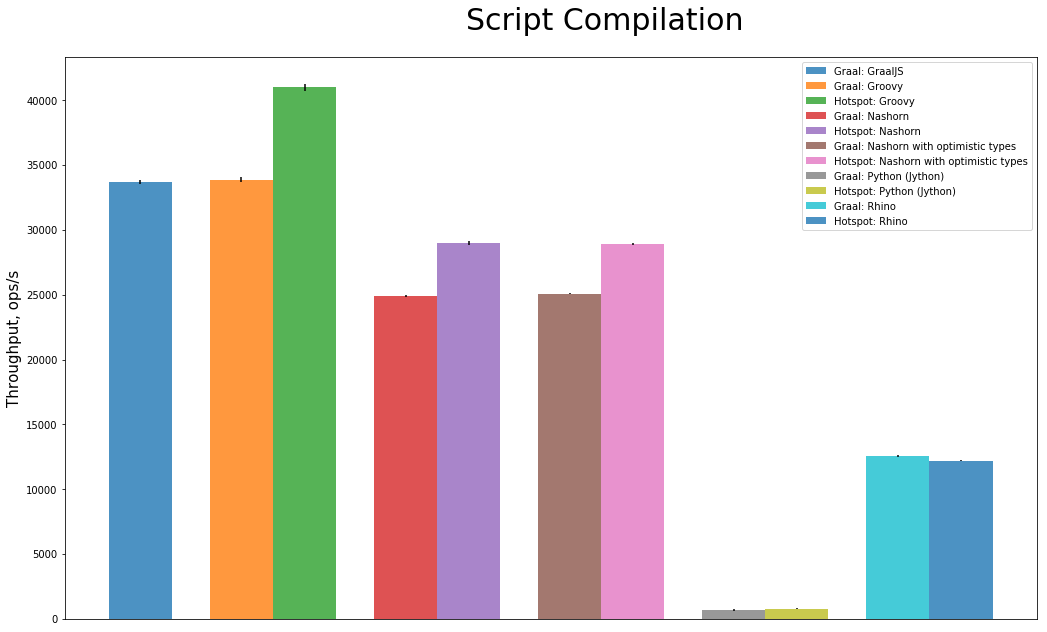

In [16]:
# compilation benchmark result plotting

bar_width = 1
opacity = 0.8

_, axis = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Script Compilation', fontsize=30, y=0.95)

result_data = {
    case: grouped_data[case]["CompilationBenchmark"]
    for case in jvm_cases
}

start_unique_bar_plotting(
    axis, 0, 
    result_data["graal"], 
    "Graal: " + result_data["graal"][0]["engine_case"],
    bar_width, opacity
)

for i in range(len(result_data["common"])):
    plot_compared_bars(
        axis, i, 1, 
        result_data["graal"], result_data["common"],
        "Graal: " + result_data["graal"][i + 1]["engine_case"], 
        "Hotspot: " + result_data["common"][i]["engine_case"],
        bar_width, opacity
    )

axis.set_ylabel('Throughput, ops/s', size=15)
axis.set_xticks([])
axis.legend()
plt.show()

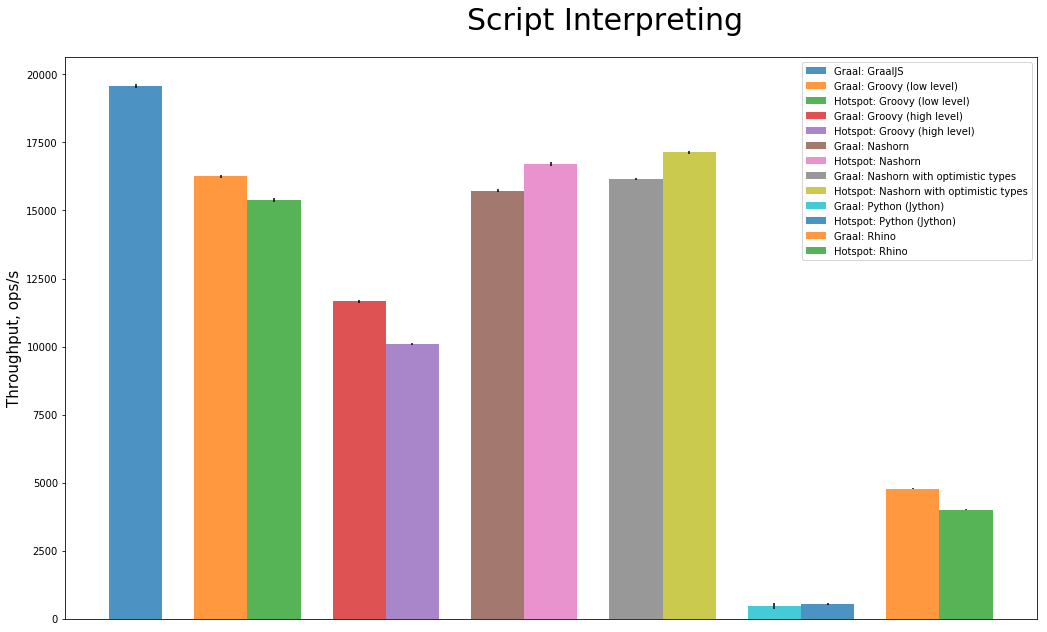

In [17]:
# interpreting benchmark result plotting

names_mapping = {
    "withForEvalScript": "Groovy (low level)",
    "withRangeEvalScript": "Groovy (high level)"
}

bar_width = 1
opacity = 0.8

_, axis = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Script Interpreting', fontsize=30, y=0.95)

result_data = {
    case: grouped_data[case]["InterpretationEvalBenchmark"]
    for case in jvm_cases
}

names = {
    case: [
        result["engine_case"]
        if result["engine_case"] is not "Groovy"
        else names_mapping[result["benchmark_method"]]
        for result in result_data[case]
    ] for case in jvm_cases
}

start_unique_bar_plotting(
    axis, 0, 
    result_data["graal"], 
    "Graal: " + names["graal"][0],
    bar_width, opacity
)

for i in range(len(result_data["common"])):
    plot_compared_bars(
        axis, i, 1,
        result_data["graal"], result_data["common"],
        "Graal: " + names["graal"][i + 1], 
        "Hotspot: " + names["common"][i],
        bar_width, opacity
    )

axis.set_ylabel('Throughput, ops/s', size=15)
axis.set_xticks([])
axis.legend()
plt.show()

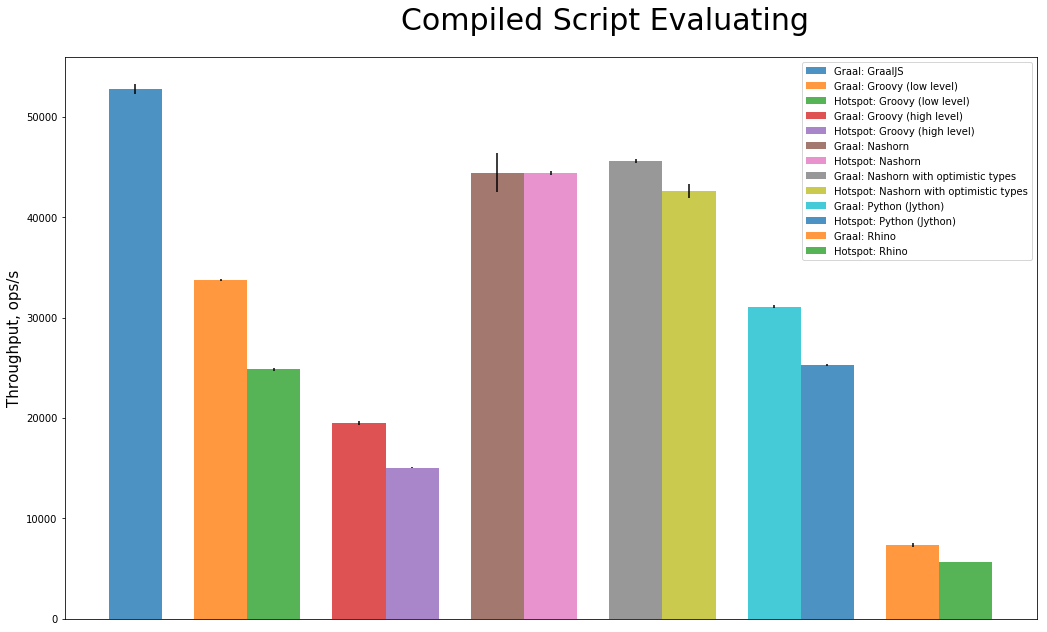

In [18]:
# compiled script evaluating benchmark result plotting

bar_width = 1
opacity = 0.8

_, axis = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Compiled Script Evaluating', fontsize=30, y=0.95)

result_data = {
    case: grouped_data[case]["CompiledEvalBenchmark"]
    for case in jvm_cases
}

names = {
    case: [
        result["engine_case"]
        if result["engine_case"] is not "Groovy"
        else names_mapping[result["benchmark_method"]]
        for result in result_data[case]
    ] for case in jvm_cases
}

start_unique_bar_plotting(
    axis, 0, 
    result_data["graal"], 
    "Graal: " + names["graal"][0],
    bar_width, opacity
)

for i in range(len(result_data["common"])):
    plot_compared_bars(
        axis, i, 1,
        result_data["graal"], result_data["common"],
        "Graal: " + names["graal"][i + 1], 
        "Hotspot: " + names["common"][i],
        bar_width, opacity
    )
    
axis.set_ylabel('Throughput, ops/s', size=15)
axis.set_xticks([])
axis.legend()
plt.show()

In [19]:
# evaluation cases mapping to human readable names
names_mapping = {
    ("Groovy", "withForEvalScript"): "Groovy (low level)",
    ("Groovy", "withRangeEvalScript"): "Groovy (high level)",
    ("Nashorn", "evalScript"): "Nashorn",
    ("Nashorn with optimistic types", "evalScript"): "Nashorn with optimistic types",
    ("Rhino", "evalScript"): "Rhino",
    ("Python (Jython)", "evalScript"): "Python (Jython)",
    ("GraalJS", "evalScript"): "GraalJS"
}
# lambda function for group ID getting
get_engine_and_method_tuple = \
    lambda item: (item["engine_case"], item["benchmark_method"])

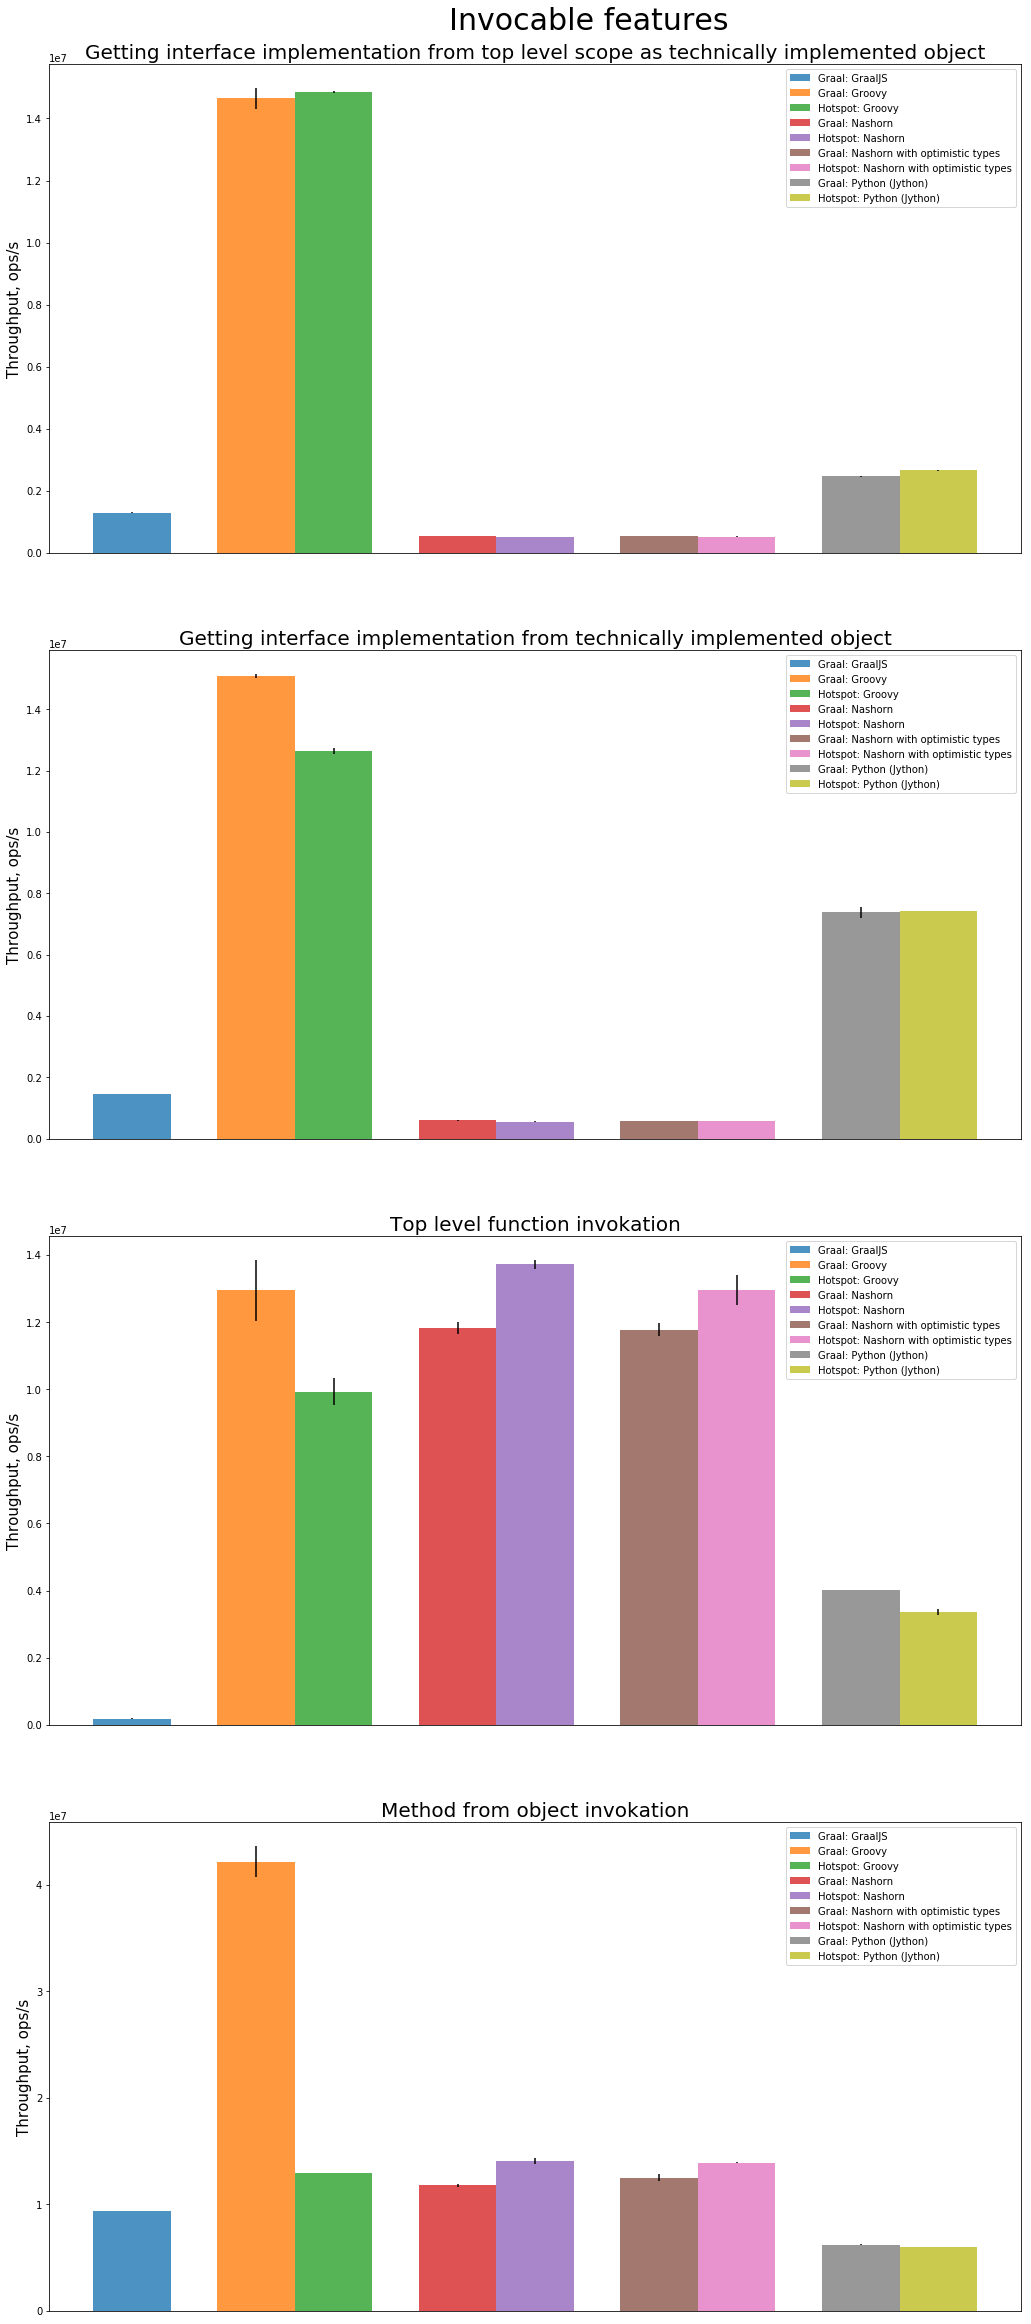

In [20]:
# invocable benchmark result plotting

names_mapping = {
    "getInterface": "Getting interface implementation "
                    "from top level scope as technically implemented object",
    "getInterfaceFromProperty": "Getting interface implementation "
                                "from technically implemented object",
    "invokeFunction": "Top level function invokation",
    "invokeMethod": "Method from object invokation"
}

bar_width = 1
opacity = 0.8

_, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 40))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Invocable features', fontsize=30, y=0.90)


result_data = {
    case: 
        groupby(
            sorted(
                grouped_data[case]["EngineAsInvocableBenchmark"], 
                key=lambda data: data["benchmark_method"]
            ), 
            key=lambda data: data["benchmark_method"]
        ) for case in jvm_cases
}

result_data = {
    case: {
        method: [result for result in result_pack] 
        for method, result_pack in result_data[case]
    } for case in jvm_cases
}
       
for num, result_key in enumerate(result_data["common"]):
    group = {case: result_data[case][result_key] for case in jvm_cases}
    
    start_unique_bar_plotting(
        axes[num], 0, 
        group["graal"], 
        "Graal: " + group["graal"][0]["engine_case"],
        bar_width, opacity
    )

    for i in range(len(result_data["common"])):
        plot_compared_bars(
            axes[num], i, 1,
            group["graal"], group["common"],
            "Graal: " + group["graal"][i + 1]["engine_case"], 
            "Hotspot: " + group["common"][i]["engine_case"],
            bar_width, opacity
        )

    axes[num].set_title(names_mapping[result_key], fontsize=20)
    axes[num].set_ylabel('Throughput, ops/s', size=15)
    axes[num].set_xticks([])
    axes[num].legend()
plt.show()

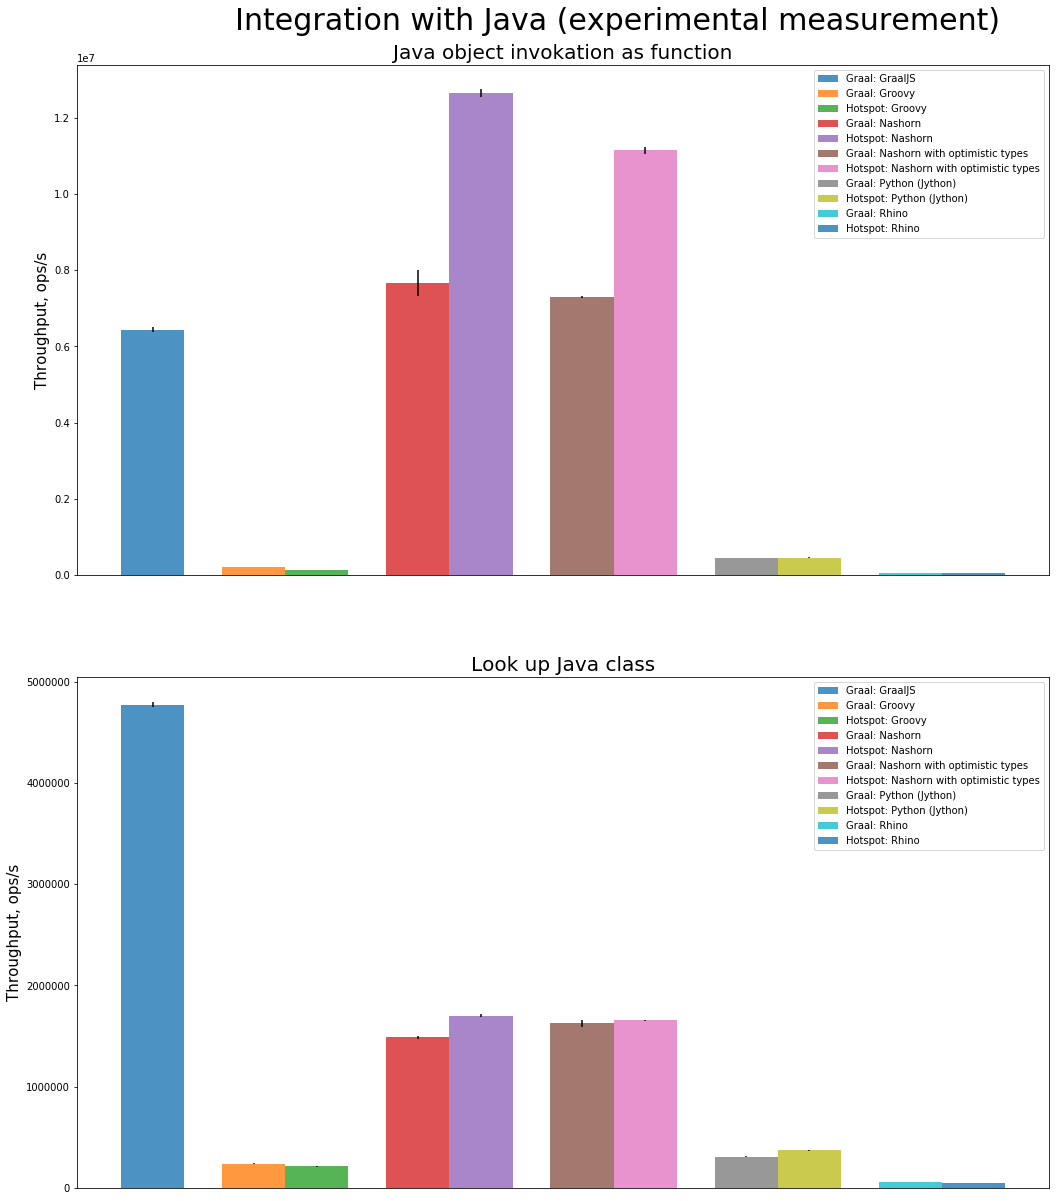

In [22]:
# experimental benchmarks result plotting (probably not acceptable)

names_mapping = {
    "InvokeObjectAsFunctionBenchmark": "Java object invokation as function",
    "LookUpClassBenchmark": "Look up Java class"
}

bar_width = 1
opacity = 0.8

_, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle(
    'Integration with Java (experimental measurement)', 
    fontsize=30, y=0.92
)

result_data = {
    case: {
        key: grouped_data[case][key] 
        for key in ("InvokeObjectAsFunctionBenchmark", "LookUpClassBenchmark")
    } for case in jvm_cases
}

for num, name in enumerate(result_data["common"]):
    group = {
        case: list(result_data[case][name])
        for case in jvm_cases
    }
    
    start_unique_bar_plotting(
        axes[num], 0, 
        group["graal"], 
        "Graal: " + group["graal"][0]["engine_case"],
        bar_width, opacity
    )
    
    for i in range(len(group["common"])):
        plot_compared_bars(
            axes[num], i, 1,
            group["graal"], group["common"],
            "Graal: " + group["graal"][i + 1]["engine_case"], 
            "Hotspot: " + group["common"][i]["engine_case"],
            bar_width, opacity
        )
        
    axes[num].set_title(names_mapping[name], fontsize=20)
    axes[num].set_ylabel('Throughput, ops/s', size=15)
    axes[num].set_xticks([])
    axes[num].legend()
plt.show()